In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from pdpbox import pdp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
import shap
shap.initjs()
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline

In [12]:
import sys, pkg_resources
print(f"# Python version: {sys.version.strip()}")
for dist in sorted(pkg_resources.working_set, key=lambda d: d.project_name.lower()):
    print(f"# {dist.project_name}=={dist.version}")

# Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
# alabaster==1.0.0
# asttokens==3.0.0
# babel==2.17.0
# bounded-pool-executor==0.0.3
# certifi==2025.1.31
# charset-normalizer==3.4.1
# cloudpickle==3.1.1
# colorama==0.4.6
# comm==0.2.2
# contourpy==1.3.2
# cycler==0.12.1
# debugpy==1.8.14
# decorator==5.2.1
# docutils==0.21.2
# executing==2.2.0
# fonttools==4.57.0
# idna==3.10
# imagesize==1.4.1
# iniconfig==2.1.0
# ipykernel==6.29.5
# ipython==9.1.0
# ipython-pygments-lexers==1.1.1
# ipywidgets==8.1.6
# jedi==0.19.2
# jinja2==3.1.6
# joblib==1.4.2
# jupyter-client==8.6.3
# jupyter-core==5.7.2
# jupyterlab-widgets==3.0.14
# kiwisolver==1.4.8
# llvmlite==0.44.0
# MarkupSafe==3.0.2
# matplotlib==3.10.1
# matplotlib-inline==0.1.7
# narwhals==1.36.0
# nest-asyncio==1.6.0
# numba==0.61.2
# numpy==2.2.5
# numpydoc==1.8.0
# packaging==25.0
# pandas==2.2.3
# parso==0.8.4
# patsy==1.0.1
# PDPbox==0.3.0
# pillow==11.2.1
# pip==25.0.1
# platformdi

Read

In [13]:
df = pd.read_csv("../data/returns_and_characteristics.csv")

Split

In [14]:
train_years = list(range(2000, 2017))  
df_train = df[df['year'].isin(train_years)].copy()
df_test  = df[~df['year'].isin(train_years)].copy()

Standardize

In [15]:
feat_cols = df_train.columns[3:97]
target_col  = df_train.columns[97]       

df_train_std = df_train[df_train[target_col].notnull()].copy()

date_cols = ['year', 'month']

# Cross‐sectional standardization + fill NaNs with 0
df_train_std[feat_cols] = (
    df_train_std
      .groupby(date_cols)[feat_cols]
      .transform(lambda x: ((x - x.mean()) / x.std()).fillna(0))
)

X_train = df_train_std[feat_cols].copy()
y_train = df_train_std[target_col].copy()


Fit elastic-net

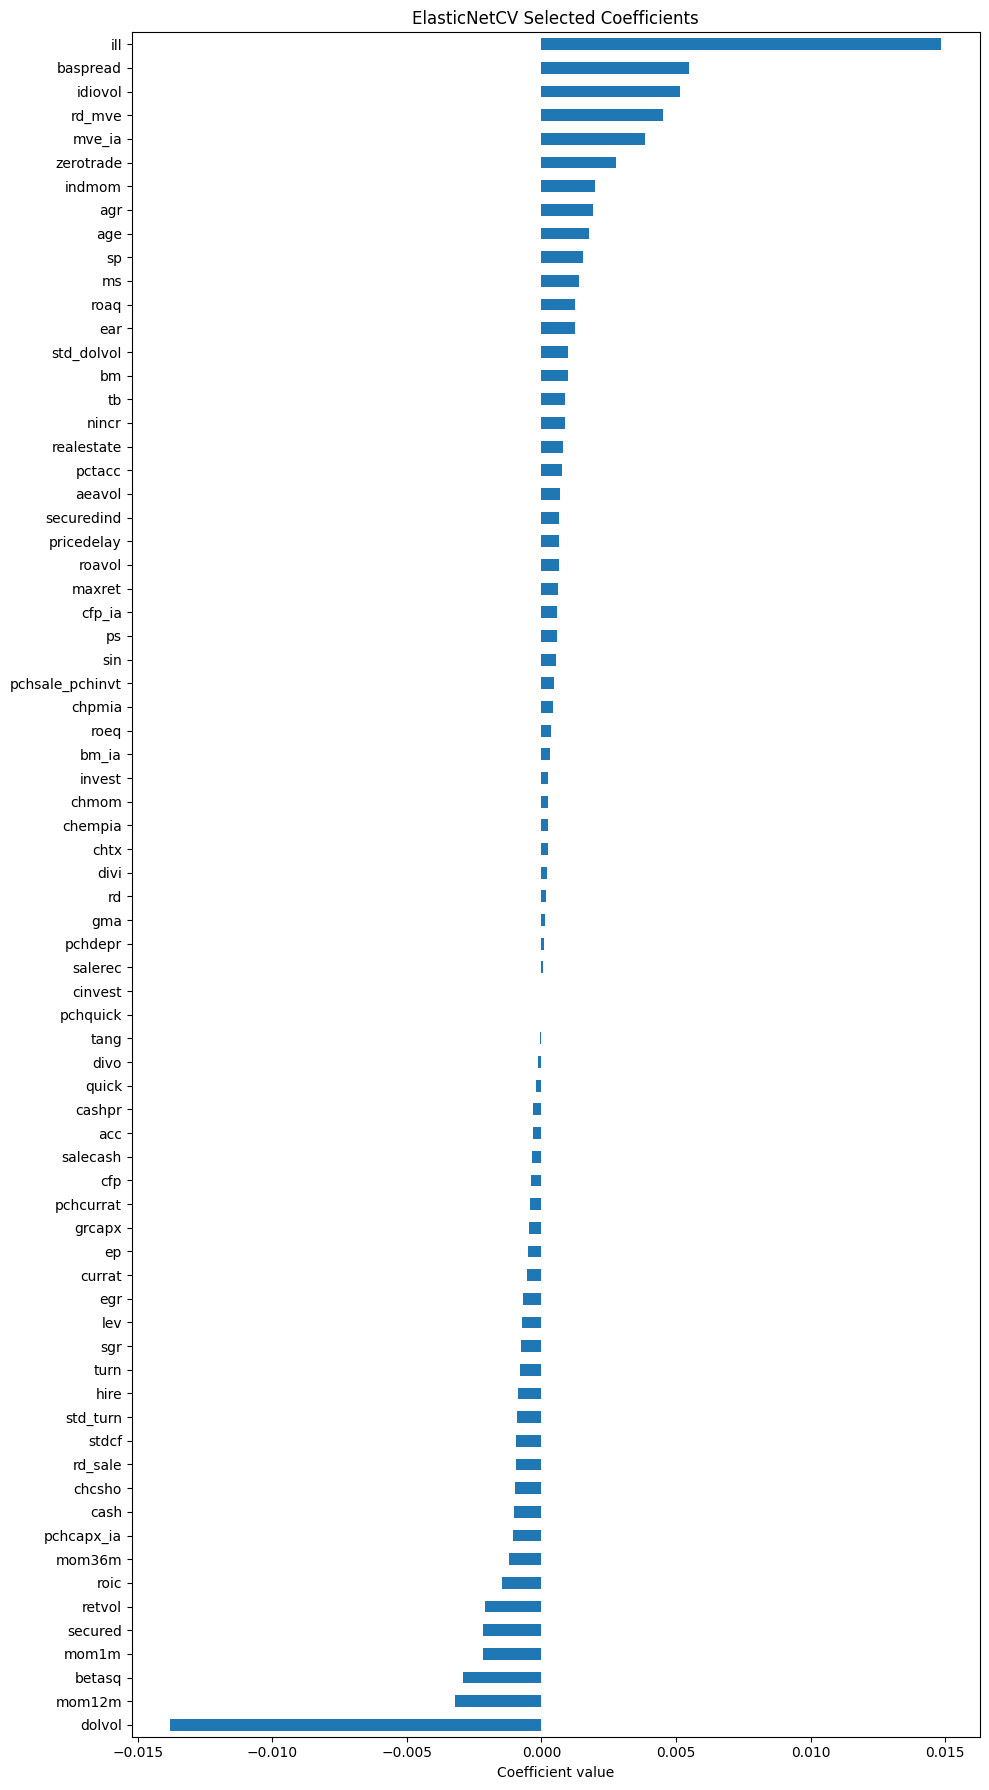

In [16]:
enet_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    cv=5,
    n_alphas=100,
    random_state=0
)
enet_cv.fit(X_train, y_train)

coef = pd.Series(enet_cv.coef_, index=X_train.columns)
coef = coef[coef.abs() > 1e-8].sort_values()

plt.figure(figsize=(10, max(4, len(coef) * 0.25)))
coef.plot.barh()
plt.title("ElasticNetCV Selected Coefficients")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()


Fit a gradient boosting 

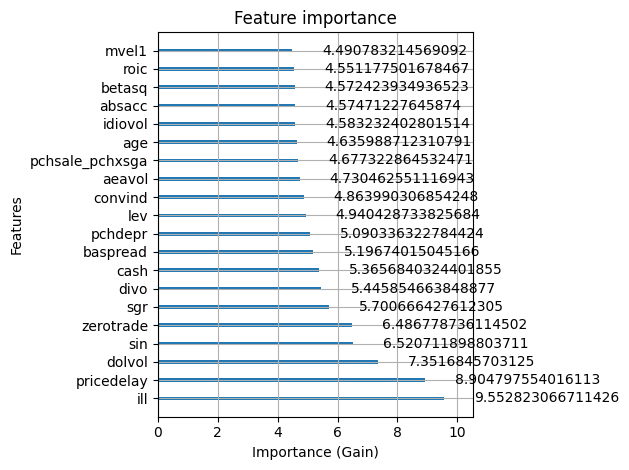

In [17]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    gamma=0.2,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=2,
    random_state=0
)
model.fit(X_train, y_train)

xgb.plot_importance(
    model,
    max_num_features=20,
    importance_type='gain',
    xlabel='Importance (Gain)'
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Model-agnostic interpretability

Permutation importance

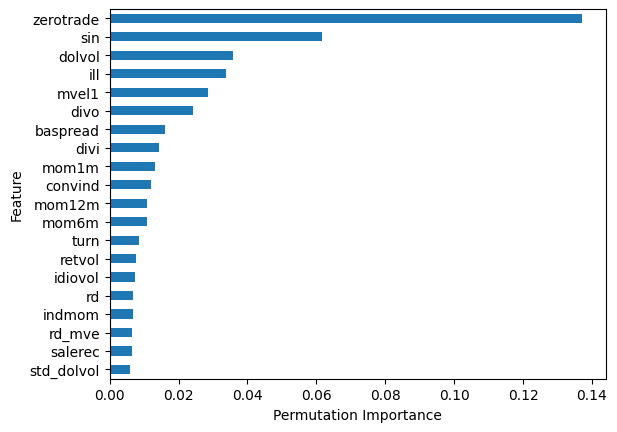

In [18]:
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=42, n_jobs=4)

importance_scores = perm_importance.importances_mean

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_scores
})

importance_df.sort_values(by='Importance', ascending=False, inplace=True)

top_20_features = importance_df[:20]

top_20_features.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()  
plt.xlabel('Permutation Importance')
plt.show()

Partial dependence plots

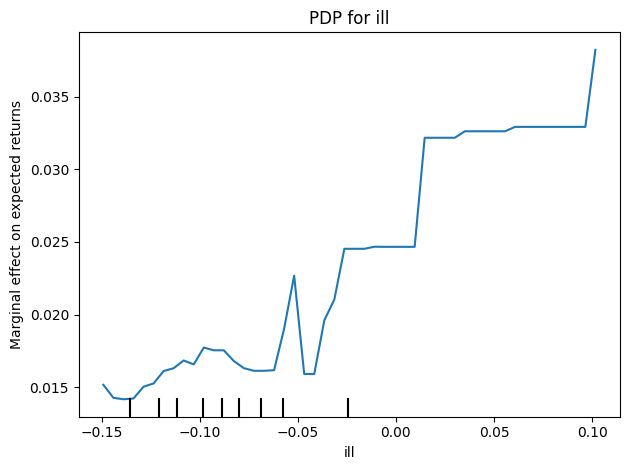

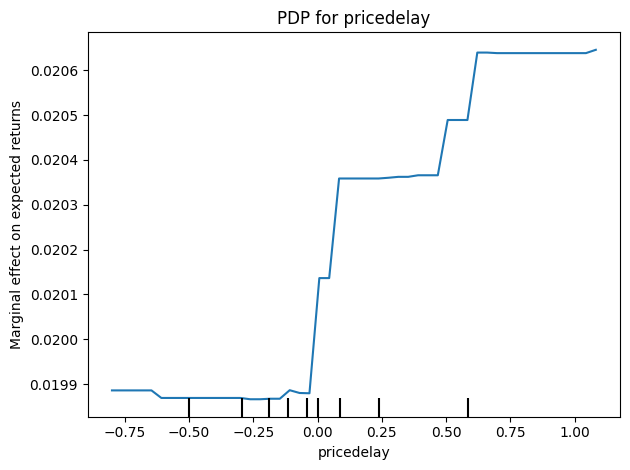

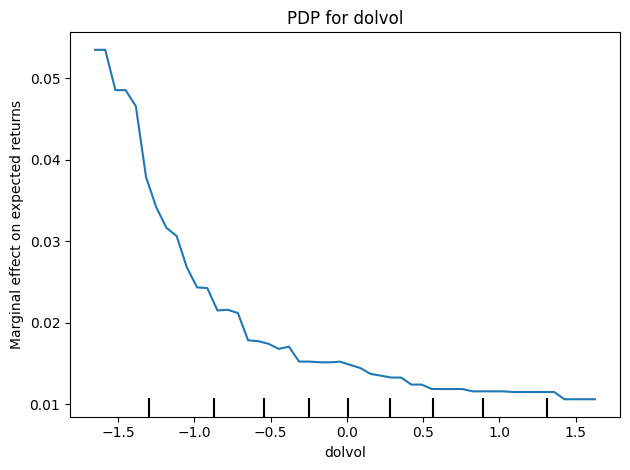

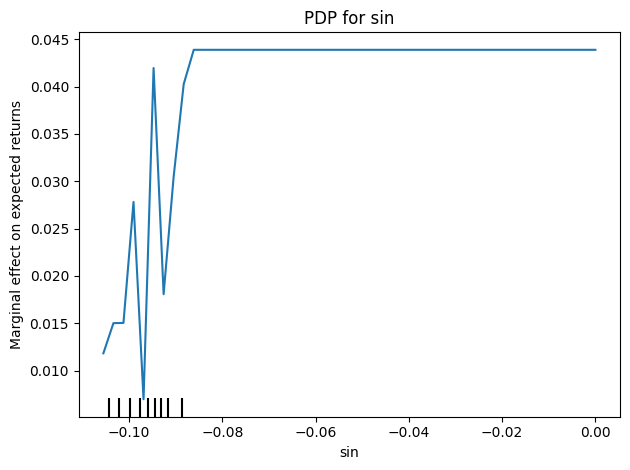

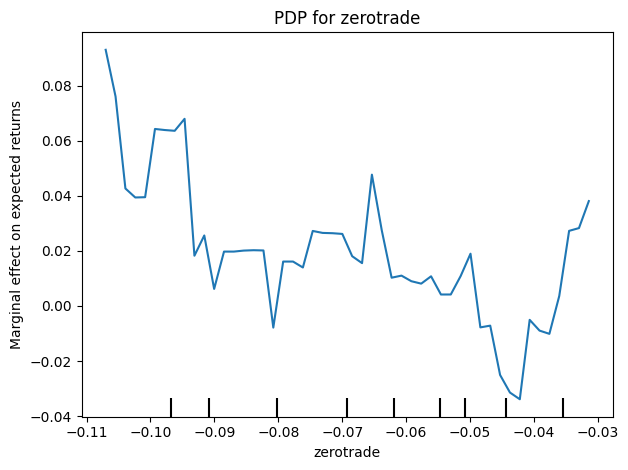

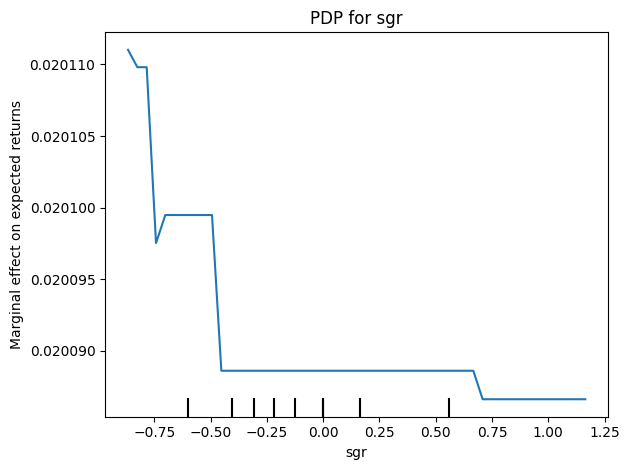

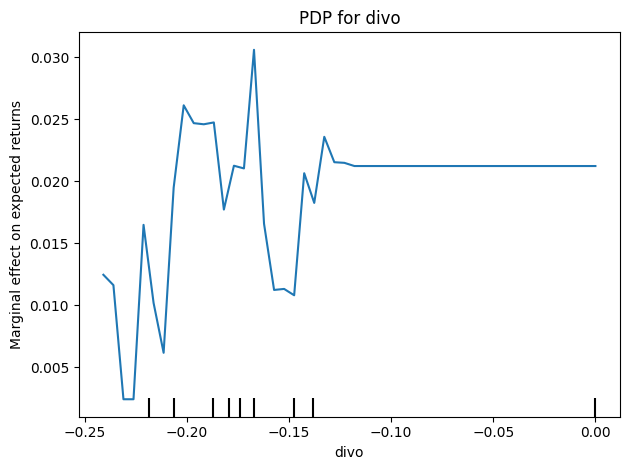

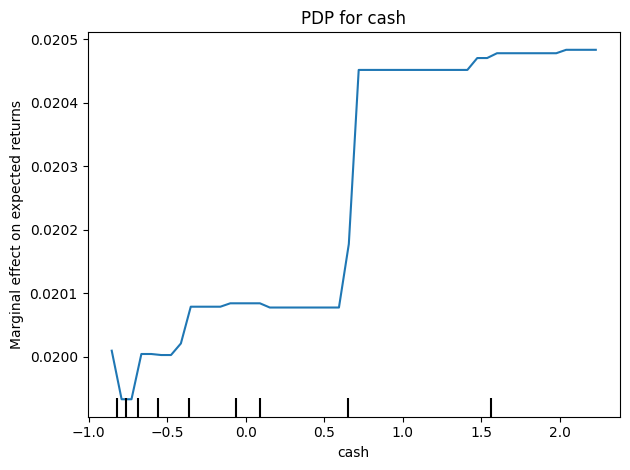

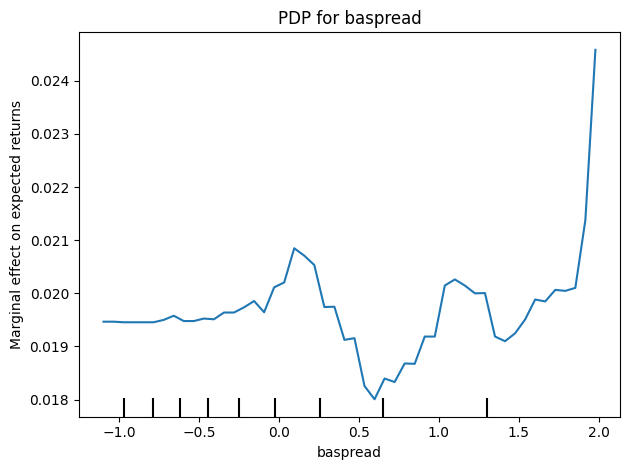

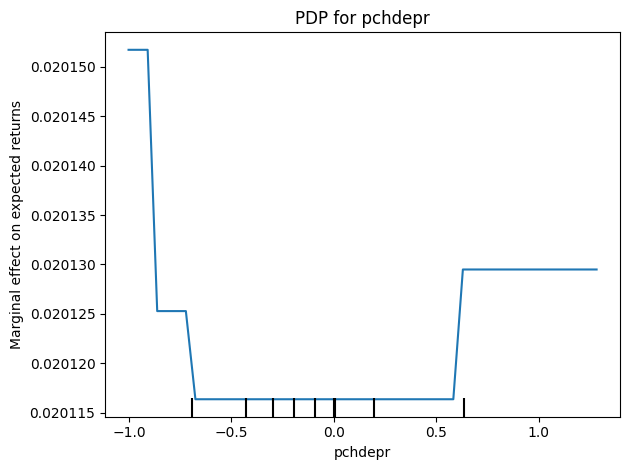

In [19]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

top10 = importance_df['Feature'].head(10).tolist()

for feat in top10:
    disp = PartialDependenceDisplay.from_estimator(
        estimator=model,
        X=X_train,
        features=[feat],
        kind='average',        
        grid_resolution=50,
        feature_names=X_train.columns
    )
    ax = disp.axes_[0, 0]
    ax.set_ylabel('Marginal effect on expected returns')
    ax.set_title(f'PDP for {feat}')
    plt.tight_layout()
    plt.show()


Accumulated local effects

In [20]:
"""
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

top_features = importance_df['Feature'][:5]

for feature in top_features:
    ale_eff = ale(
    X=X_train,
    model=model,
    feature=[feature],
    grid_size=50,
    include_CI=False
)
"""

"\nimportance_df = pd.DataFrame({\n    'Feature': X_train.columns,\n    'Importance': model.feature_importances_\n}).sort_values('Importance', ascending=False)\n\ntop_features = importance_df['Feature'][:5]\n\nfor feature in top_features:\n    ale_eff = ale(\n    X=X_train,\n    model=model,\n    feature=[feature],\n    grid_size=50,\n    include_CI=False\n)\n"

Surrogate model

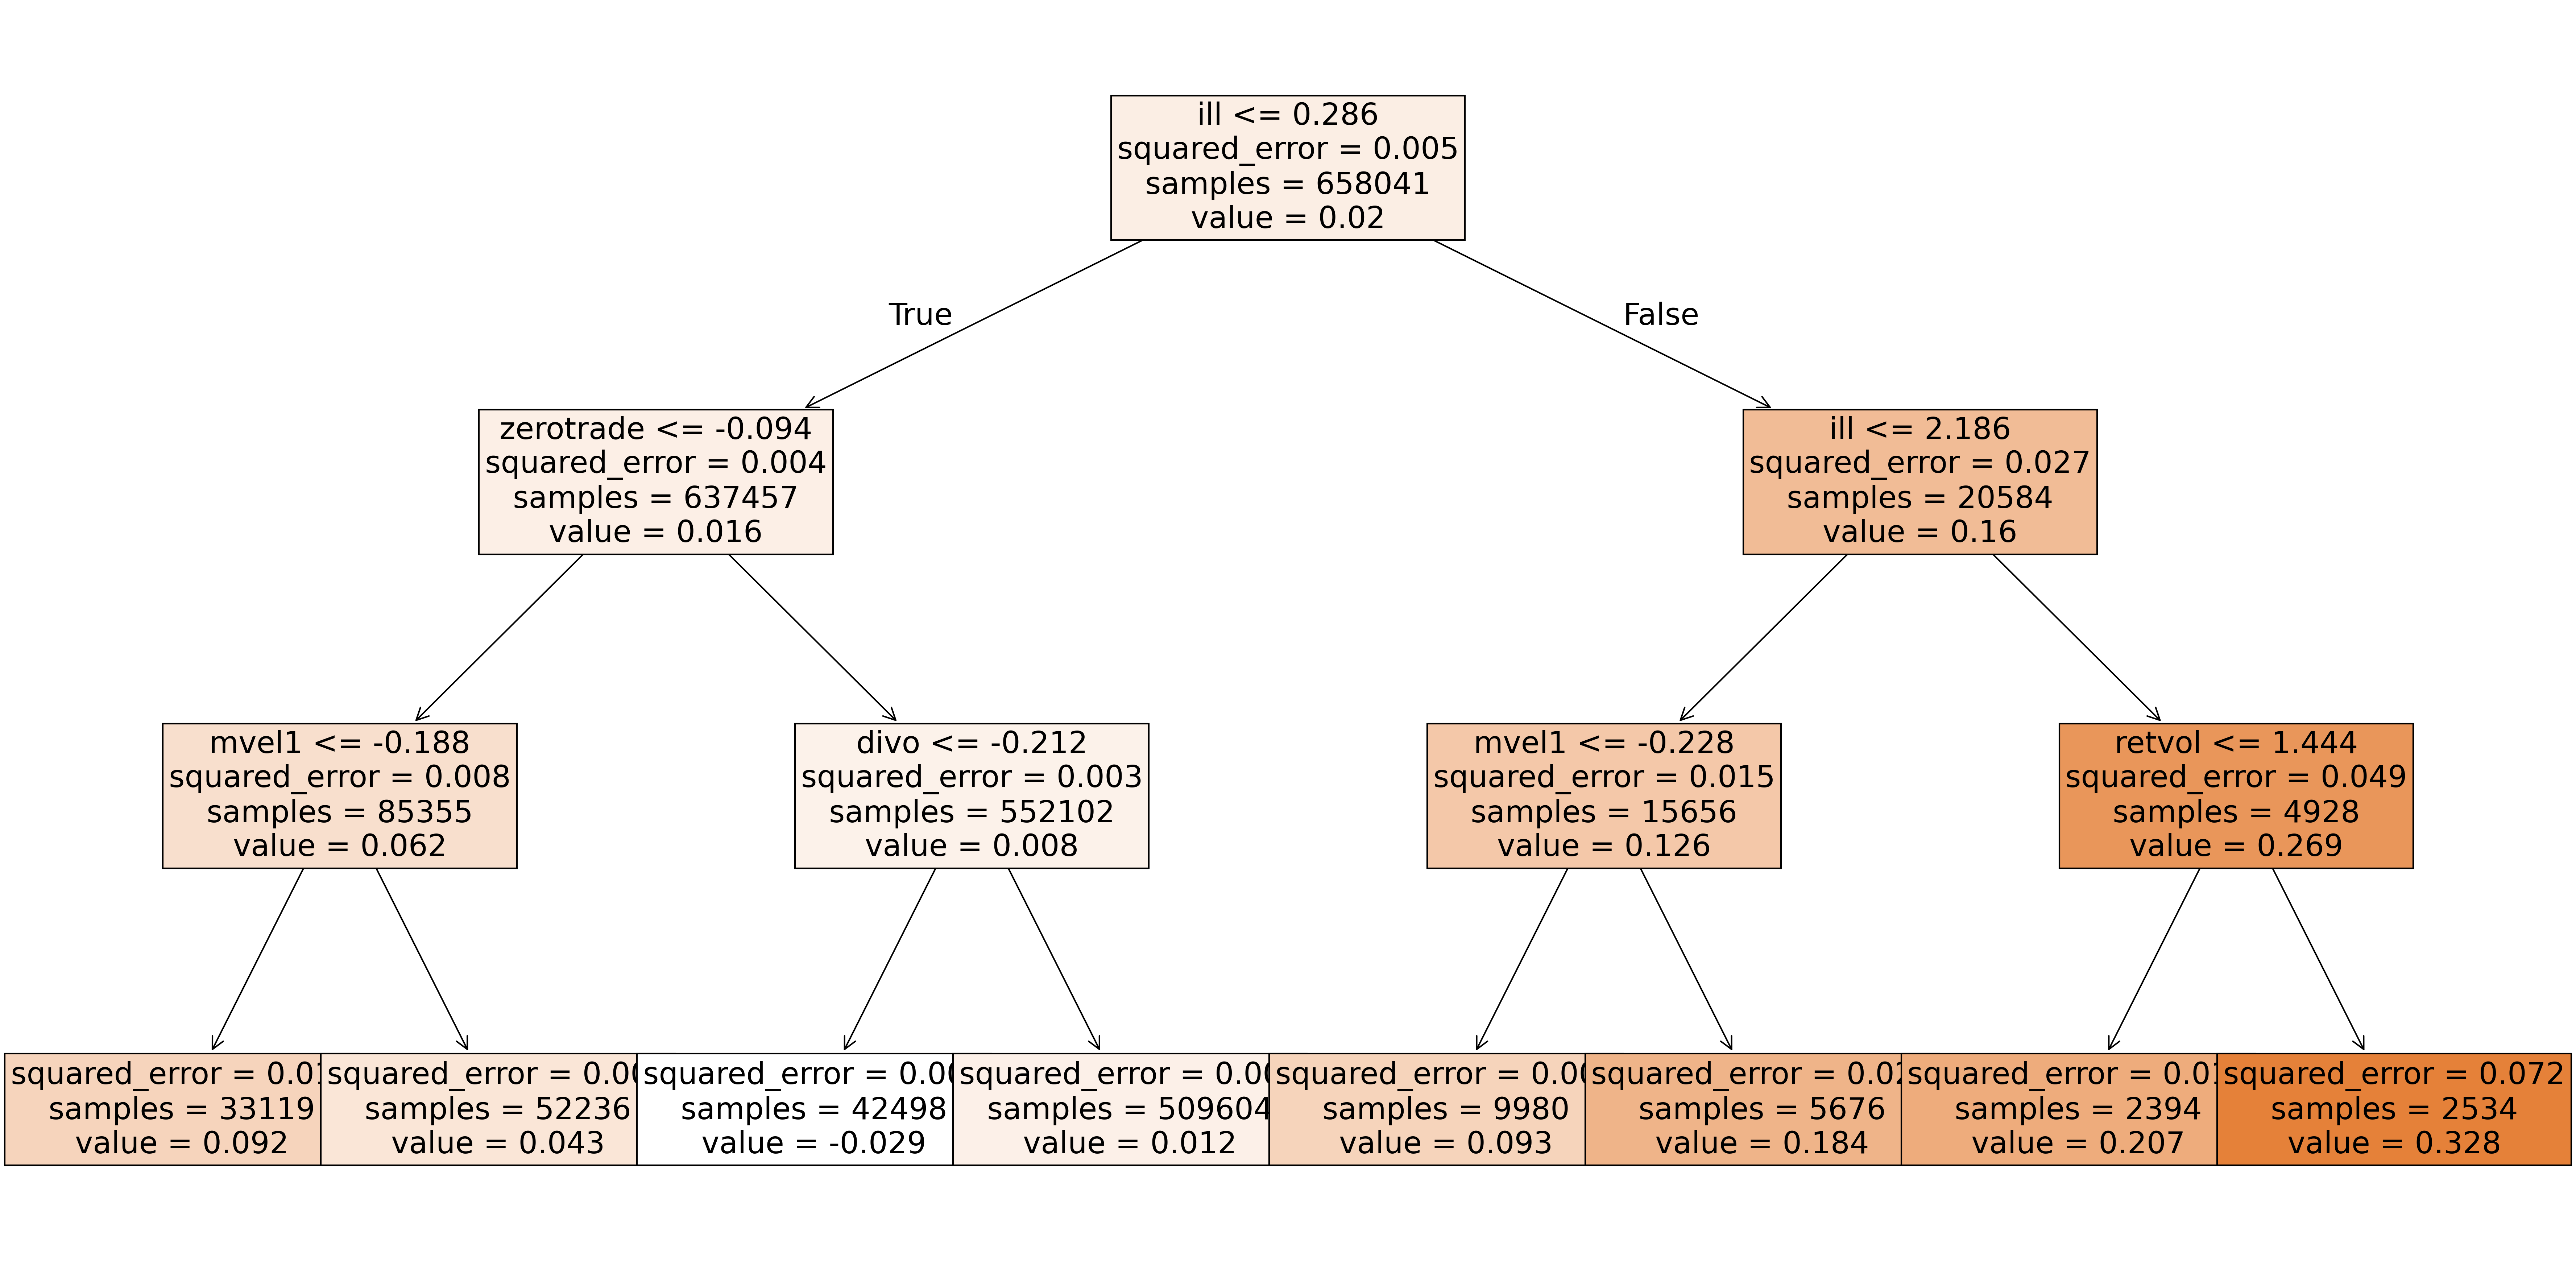

In [21]:
# Train a surrogate decision tree
surrogate = DecisionTreeRegressor(max_depth=3)
surrogate.fit(X_train, model.predict(X_train))

plt.figure(figsize=(30,15), dpi=300)  
plot_tree(surrogate, feature_names=X_train.columns, filled=True, fontsize=20)
plt.show()

Comparing MSE of gradient boosting, a decision tree model and a surrogate model

In [22]:
# Decision tree model
Decision_Tree = DecisionTreeRegressor(max_depth=3)
Decision_Tree.fit(X_train, y_train)
Decision_Tree_predictions = Decision_Tree.predict(X_train)
Decision_Tree_mse = mean_squared_error(y_train, Decision_Tree_predictions)

# Predictions from the original model (boosted trees)
original_model_predictions = model.predict(X_train)

# Predictions from the surrogate model
surrogate_predictions = surrogate.predict(X_train)

# Calculate the mean squared error of the surrogate model
surrogate_mse = mean_squared_error(original_model_predictions, surrogate_predictions)

# Calculate the mean squared error of the original model
original_model_mse = mean_squared_error(y_train, original_model_predictions)

# Print the results
print(f"Mean Squared Error of the Decision Tree Model: {Decision_Tree_mse}")
print(f"Mean Squared Error of the Original Model: {original_model_mse}")
print(f"Mean Squared Error of the Surrogate Model: {surrogate_mse}")


Mean Squared Error of the Decision Tree Model: 0.03629647242214836
Mean Squared Error of the Original Model: 0.028229884755099088
Mean Squared Error of the Surrogate Model: 0.003993105947807189


Shapley values

In [23]:
# Create Explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X_train)

Global interpretability

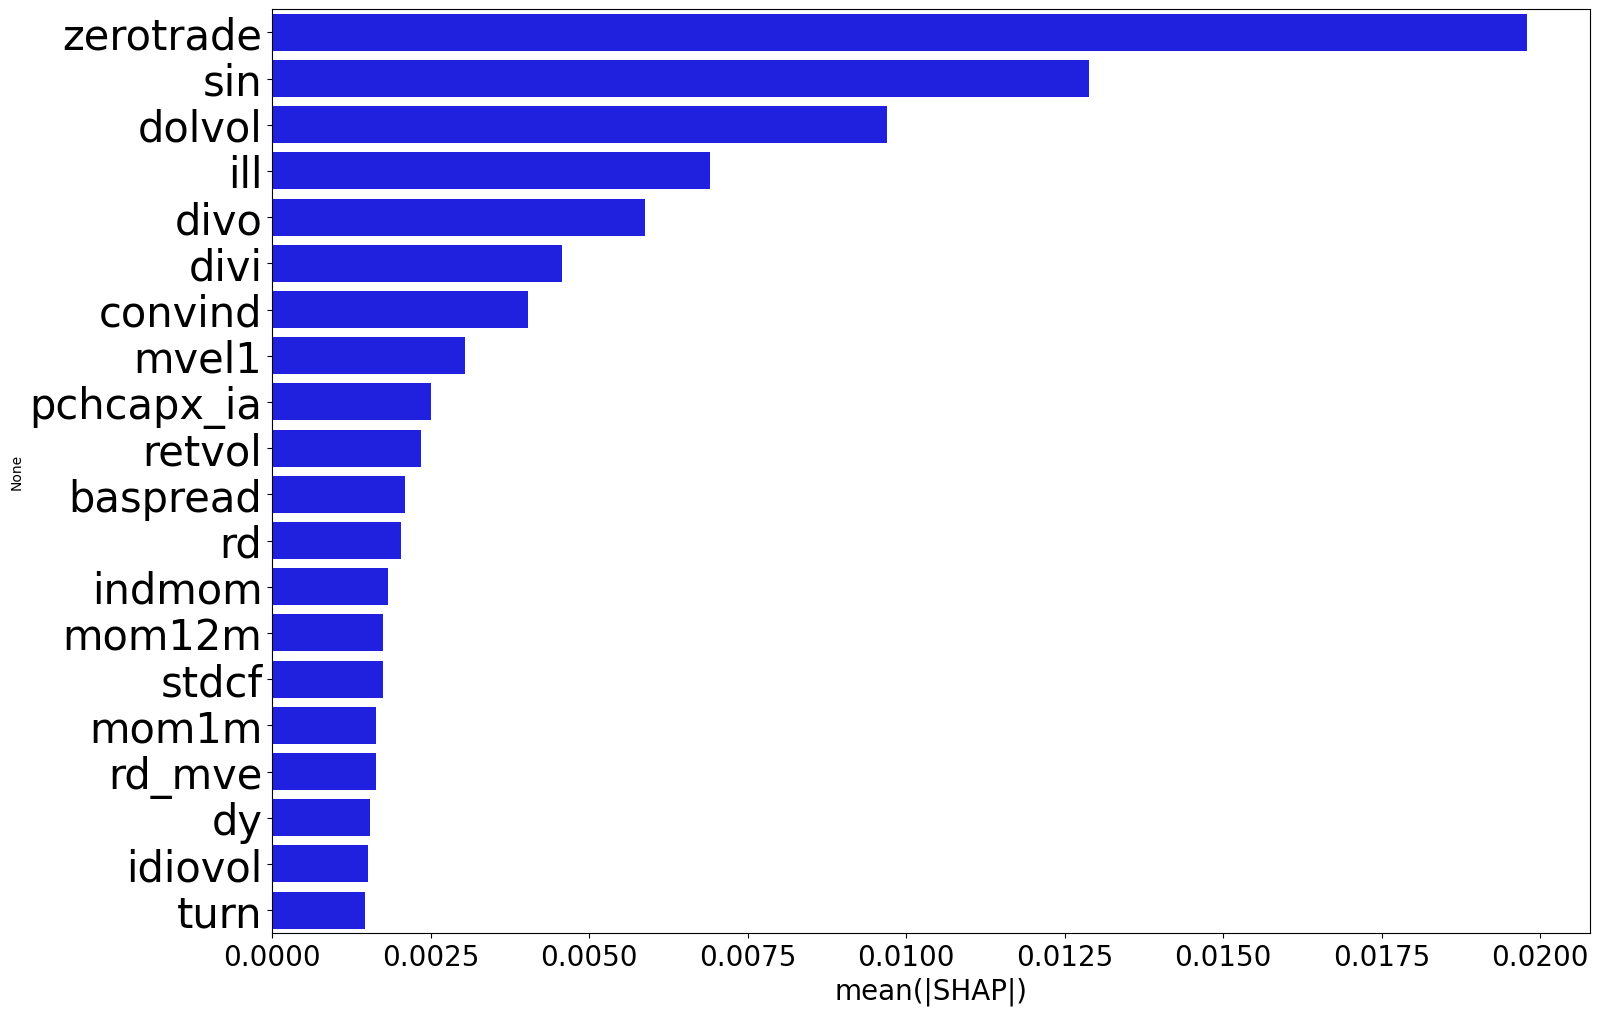

In [24]:
abs_shap_values = np.abs(shap_values.values)
abs_shap_values = pd.DataFrame(abs_shap_values,columns=X_train.columns)
abs_shap_values_mean=abs_shap_values.mean(0)
abs_shap_values_mean = abs_shap_values_mean.sort_values(ascending=False)
my_order = abs_shap_values_mean.index

top_20_features = abs_shap_values_mean[:20]

fig, ax = plt.subplots(figsize=(17, 12))
plt.yticks(fontsize=30)
plt.xticks(fontsize=20)
ax.grid(False)
plt.gca().set_facecolor('white')
sns.barplot(x=top_20_features.values, y=top_20_features.index, orient="h",color="blue")
plt.xlabel('mean(|SHAP|)', fontsize=20)
plt.show()

Local interpretability

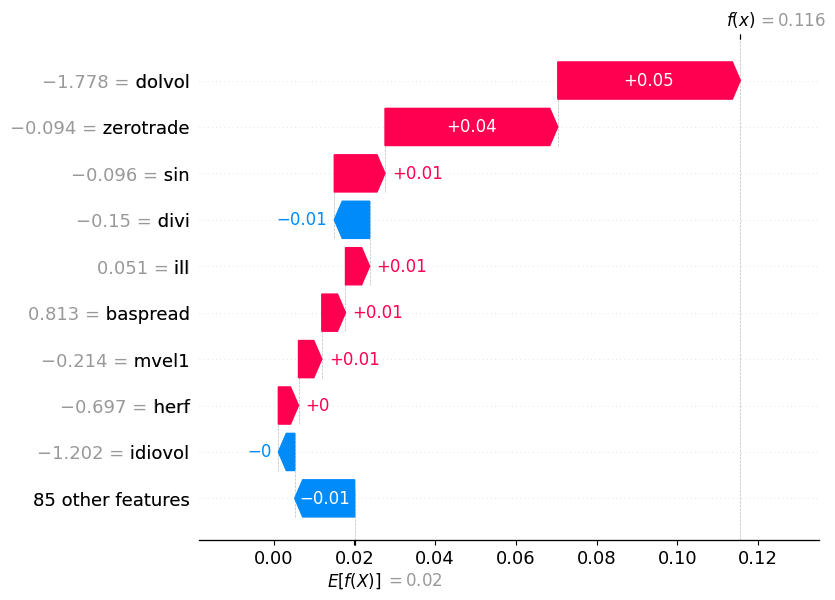

In [25]:
# First observation

shap.plots.waterfall(shap_values[0])